In [49]:
import os
import re
from datetime import timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
pd.options.plotting.backend = "plotly"
template = "plotly_dark"

In [3]:
def load_price_timeseries(file: str) -> pd.Series:
    df = pd.read_csv(file)
    df.index = pd.to_datetime(df["Date"], format="%d/%m/%Y %H:%M")
    return df["Intraday Continuous 15 minutes ID1-Price"]  # * 1e-6 # €/MWh -> €/Wh

In [4]:
def load_imbalance_prices(file: str) -> pd.Series:
    df = pd.read_csv(file, sep=";", decimal=",")
    t = pd.to_datetime(df["Datum"] + " " + df["von"], format='%d.%m.%Y %H:%M') 
    df["datetime"] = pd.date_range(t.iloc[0], t.iloc[-1], freq="15Min") # avoid repeated indices from daylight saving time change
    df = df.set_index("datetime")
    return df

In [5]:
def load_results(dir):
    res = {}
    files = [f for f in os.listdir(dir) if f.endswith(".parquet")]
    for file in files:
        name, _ = os.path.splitext(file)
        res[name] = pd.read_parquet(dir + file)

    return res

In [6]:
def exctract_value(string, key):
    match = re.search(fr"{key}=([\d.]+)", string)
    if match:
        value = match.group(1)
    return float(value)

In [7]:
def calc_fec(df):
    power = df["power_sim"]
    power_pos = power[power > 0].sum() * (1 / 60)
    power_neg = power[power < 0].abs().sum() * (1 / 60)
    return (power_pos + power_neg) / 2 / 180e3

In [8]:
def calc_roundtrip_efficiency(res):
    p = res["power_sim"]
    e_pos = p[p > 0].abs().sum() * (1 / 60)  # Wh
    e_neg = p[p < 0].abs().sum() * (1 / 60)  # Wh

    delta_soc = res["soc_sim"].iloc[-1] - res["soc_sim"].iloc[0]
    delta_e = delta_soc * 180e3  # Wh

    return abs(e_neg) / (e_pos - delta_e)

In [9]:
def calc_revenue(df, price):
    price = price.resample("1Min").ffill()
    df = df.join(price)
    return -1 * sum(df["power_opt"] * df["Intraday Continuous 15 minutes ID1-Price"]) * (1/60) * 1e-6  # W -> MWh

In [10]:
def calculate_imbalance_cost(df, price):
    price = price.resample("1Min").ffill()
    df = df.join(price)
    df["imb"] = -(df["power_opt"] - df["power_sim"]) * (1 / 60) * 1e-6 # MWh
    # negation since positive power is charging
    
    # BESS under-supply
    df_u = df.loc[df.imb > 0]
    cost_u = sum(df_u["imb"] * df_u["reBAP unterdeckt"])
    
    # BESS over-supply
    df_o = df.loc[df.imb < 0]
    cost_o = sum(df_o["imb"] * df_o["reBAP ueberdeckt"])

    return cost_u + cost_o

In [28]:
def analyse_results_lp(res, price, price_imb):
    out = pd.DataFrame()
    for (id, df) in res.items():
        if "LP" in id:
            data = dict(
                cells=exctract_value(id, "cells"),
                fec_limit = exctract_value(id, "fec"),
                r = exctract_value(id, "r"),
                # eff = exctract_value(id, "eff"),
                throughput = calc_fec(df),
                rountrip_eff = calc_roundtrip_efficiency(df),
                rev = calc_revenue(df, price),
                imb = calculate_imbalance_cost(df, price_imb),
            )
            out = pd.concat([out, pd.DataFrame(data=[data])])

    out["total"] = out["rev"] - out["imb"]
    return out

In [29]:
def analyse_results_nl(res, price, price_imb):
    out = pd.DataFrame()
    for (id, df) in res.items():
        if ("NL" in id) and ("min" not in id):
        # if ("NL" in id) and ("300" in id):
            data = dict(
                cells=exctract_value(id, "cells"),
                fec_limit = exctract_value(id, "fec"),
                r = exctract_value(id, "r"),
                # r_opt = exctract_value(id, "r_opt"),
                throughput = calc_fec(df),
                rountrip_eff = calc_roundtrip_efficiency(df),
                rev = calc_revenue(df, price),
                imb = calculate_imbalance_cost(df, price_imb),
            )
            out = pd.concat([out, pd.DataFrame(data=[data])])
        
    out["total"] = out["rev"] - out["imb"]
    return out

In [30]:
price_2021 = load_price_timeseries("data/intraday_prices/electricity_prices_germany_2021.csv")
price_2022 = load_price_timeseries("data/intraday_prices/electricity_prices_germany_2022.csv")

In [31]:
imb_2021 = load_imbalance_prices("data/balancing_energy_prices/reBAP_2021.csv")
imb_2022 = load_imbalance_prices("data/balancing_energy_prices/reBAP_2022.csv")

In [32]:
dir = "results/"
res = load_results(dir)

# res_2019 = {key: value for key, value in res.items() if "2019" in key}
res_2021 = {key: value for key, value in res.items() if "2021" in key}
res_2022 = {key: value for key, value in res.items() if "2022" in key}

In [79]:
df_nl_2021 = analyse_results_nl(res_2021, price=price_2021, price_imb=imb_2021)
df_nl_2022 = analyse_results_nl(res_2022, price=price_2022, price_imb=imb_2022)
df_nl_2022

cells  fec_limit    r  throughput  rountrip_eff          rev       imb  \
0  260.0        1.5  1.0   38.287607      0.921316  1279.336208 -0.536059   
0  261.0        1.5  1.0   40.130036      0.921214  1296.274910 -0.396183   
0  260.0        1.5  2.0   39.678515      0.895299  1253.522906 -0.107190   
0  261.0        1.5  2.0   39.851418      0.896104  1258.962762 -0.181054   
0  260.0        1.5  3.0   39.480238      0.873952  1210.834619 -0.120583   
0  261.0        1.5  3.0   39.246598      0.874256  1203.797587 -0.112262   

         total  
0  1279.872267  
0  1296.671093  
0  1253.630096  
0  1259.143816  
0  1210.955202  
0  1203.909849

In [82]:
df_lp_2021 = analyse_results_lp(res_2021, price=price_2021, price_imb=imb_2021)
df_lp_2022 = analyse_results_lp(res_2022, price=price_2022, price_imb=imb_2022)
df_lp_2022

cells  fec_limit    r  throughput  rountrip_eff          rev        imb  \
0  260.0        1.5  1.0   39.747060      0.917115  1353.784972  11.879086   
0  261.0        1.5  1.0   39.826565      0.917144  1354.653672  10.983249   
0  260.0        1.5  2.0   39.411544      0.885218  1294.985616   3.064467   
0  261.0        1.5  2.0   39.497236      0.885348  1296.838634   2.477164   
0  260.0        1.5  3.0   39.032448      0.854693  1228.564007 -11.804046   
0  261.0        1.5  3.0   39.117950      0.854926  1230.705996 -12.345755   

         total  
0  1341.905885  
0  1343.670423  
0  1291.921150  
0  1294.361470  
0  1240.368053  
0  1243.051751

In [36]:
res["2021 NL fec=1.5 r=1.0 r_opt=1.0 cells=260"]

0.026785714285714284

Text(0, 0.5, 'Imbalance power in p.u.')

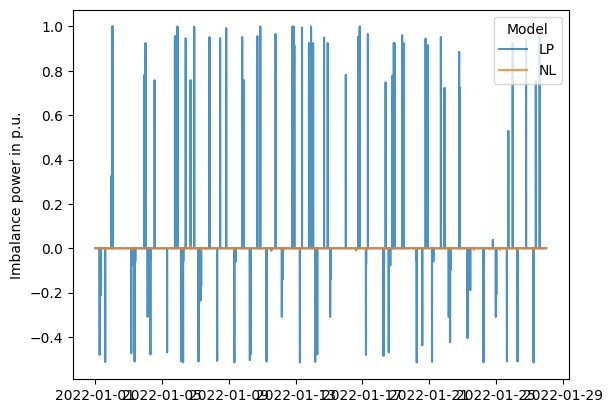

In [84]:
df_lp = res["2022 LP fec=1.5 r=3.0 eff=0.95 cells=260"]
df_lp["imb"] = -(df_lp["power_opt"] - df_lp["power_sim"])

df_nl = res["2022 NL fec=1.5 r=3.0 r_opt=3.0 cells=260"]
df_nl["imb"] = -(df_nl["power_opt"] - df_nl["power_sim"])

fig, ax = plt.subplots()
ax.plot(df_lp.index, df_lp["imb"] / 180e3, label="LP", alpha=0.8)
ax.plot(df_lp.index, df_nl["imb"] / 180e3, label="NL", alpha=0.8)
ax.legend(loc="upper right", title="Model")
ax.set_ylabel("Imbalance power in p.u.")

In [65]:
def plot_soc_error(df, **kwargs):
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
    fig.update_layout(**kwargs)
    
    fig.add_trace(go.Scatter(x=df.index, y=df["soc_sim"], name="SOC sim"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df["soc_opt"], name="SOC opt"), row=1, col=1)

    delta = df["soc_opt"] - df["soc_sim"]
    fig.add_trace(go.Scatter(x=df.index, y=delta, name="ΔSOC"), row=2, col=1)

    return fig

# plot_soc_error(df_nl, template=template, height=600)

In [64]:
# id = pd.date_range(start="2021-01-01 00:00:00", end="2021-01-28 00:29:00", freq=timedelta(minutes=15))
# plot_soc_error(df_nl.loc[id], template=template, height=600)

In [77]:
def plot_power_price(df, price, **kwargs):
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
    fig.update_layout(**kwargs)

    fig.add_trace(go.Scatter(x=df.index, y=df["power_sim"], name="P sim"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=df["power_opt"], name="P opt"), row=1, col=1)


    fig.add_trace(go.Scatter(x=price.index, y=price_2021.values, line_shape='hv', name="price"), row=2, col=1)

    return fig

In [87]:
plot_power_price(df_nl, price_2022.loc["2022-01-01":"2022-01-28"], template=template)

In [88]:
plot_power_price(df_lp, price_2022.loc["2022-01-01":"2022-01-28"], template=template)